# Import packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter

# Read dataset 

In [2]:
reviews = pd.read_csv('../datasets/hotel_reviews.csv')

In [3]:
reviews.head()

,id,dateadded,dateupdated,address,categories,primarycategories,city,country,keys,latitude,longitude,name,postalcode,province,reviews_date,reviews_dateseen,reviews_rating,reviews_sourceurls,reviews_text,reviews_title,reviews_usercity,reviews_userprovince,reviews_username,sourceurls,websites,location
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2013-11-14T00:00:00Z,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2014-07-06T00:00:00Z,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2015-01-02T00:00:00Z,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,POINT(-117.186136 32.990959)
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-05-15T00:00:00Z,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-07-09T00:00:00Z,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,POINT(-76.716341 39.155929)


In [4]:
reviews.shape

(10000, 26)

# EDA

# There are 1853 hotels to choose from 

In [5]:
len(reviews.id.unique())

1853

# All the hotels are present in US

In [6]:
len(reviews.country.unique())

1

In [7]:
reviews.country.unique()

array(['US'], dtype=object)

# It is not the case that each hotel has only 1 unique rating. Same hotel can have a different rating based on the reviews

For the purpose of this exercise we will only focus on predicting the score from review text and title. If the hotel has multiple reviews we can average out the score of different reviews to reach a final rating for a particular hotel

In [8]:
len(reviews[['id','reviews_rating']].drop_duplicates())

3782

In [9]:
reviews[reviews['id'] == 'AVwdOclqIN2L1WUfti38'][['id','reviews_rating']]

,id,reviews_rating
3,AVwdOclqIN2L1WUfti38,2.0
4,AVwdOclqIN2L1WUfti38,5.0
5,AVwdOclqIN2L1WUfti38,5.0
6,AVwdOclqIN2L1WUfti38,5.0
7,AVwdOclqIN2L1WUfti38,5.0
8,AVwdOclqIN2L1WUfti38,5.0


# The ratings are a continuous variable from 1 to 5. We need to be mindful of that when building a model

In [10]:
sorted(reviews.reviews_rating.unique())

[1.0,
 1.25,
 1.45,
 1.65,
 1.9,
 2.0,
 2.1,
 2.3,
 2.5,
 2.7,
 2.75,
 2.9,
 3.0,
 3.15,
 3.25,
 3.35,
 3.45,
 3.5,
 3.55,
 3.75,
 3.95,
 4.0,
 4.15,
 4.25,
 4.4,
 4.5,
 4.6,
 4.75,
 4.8,
 5.0]

# We can see that the hotels are spread across the US with a few properties even in remote places like alaska. After plotting lat and long coordinates on a  map, we can see that the good properties (5 rating) are spread across the US

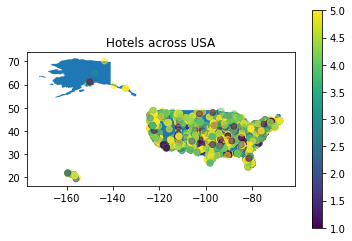

In [11]:
df_geo = gpd.GeoDataFrame(reviews, geometry=gpd.points_from_xy(reviews.longitude, reviews.latitude))

world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

axis = world_data[world_data.name == 'United States of America'].plot()

df_geo.plot(column = 'reviews_rating' , ax=axis, alpha=0.5, legend=True)
plt.title('Hotels across USA')
plt.show()

# Rhode island state has highest rated hotels and the state Delaware has lowest rated hotels

In [12]:
pd.DataFrame(reviews.groupby('province')['reviews_rating']\
             .mean()).reset_index()\
             .sort_values(by=['reviews_rating'],ascending=False)\
             .reset_index(drop=True)   

,province,reviews_rating
0,RI,4.600000
1,MS,4.500000
2,HI,4.358491
3,ID,4.339286
4,CT,4.300000
5,NM,4.285714
6,MA,4.277232
7,MO,4.250000
8,SC,4.239057
9,MT,4.222222


# Preprocess the data by removing  punctuation, stopwords, numbers and finding lemma of words. Use the preprocessed data to find the most common words in 5 star reviews title and text

In [13]:
def text_process(text):
    if type(text) == float:
        return []
    else:
        nopunc = [str(i).lower() for i in text if i not in string.punctuation]
        nopunc_text = ''.join(nopunc)
        lemmatizer = WordNetLemmatizer()
        nonpunc_nonstopwords_lemma_text = [lemmatizer.lemmatize(i) for i in nopunc_text.split() if i not in stopwords.words('english')]
        return nonpunc_nonstopwords_lemma_text

text_ratings = reviews.loc[:,['id','reviews_rating', 'reviews_text', 'reviews_title']]

text_ratings.loc[:,'reviews_text'] = text_ratings.apply(lambda row: text_process(row['reviews_text']),axis=1)
text_ratings.loc[:,'reviews_title'] = text_ratings.apply(lambda row: text_process(row['reviews_title']),axis=1)

all_words_text_5 = [j for i in text_ratings[text_ratings['reviews_rating']==5]['reviews_text'] for j in i]
all_words_title_5 = [j for i in text_ratings[text_ratings['reviews_rating']==5]['reviews_title'] for j in i]

counts_5_text = Counter(all_words_text_5)
counts_5_title = Counter(all_words_title_5)

We can see that the top reviews have common words like great , clean, breakfast, friendly

In [14]:
counts_5_text.most_common(15)

[('hotel', 3251),
 ('room', 3173),
 ('staff', 2145),
 ('great', 2134),
 ('stay', 1952),
 ('clean', 1581),
 ('breakfast', 1312),
 ('nice', 1282),
 ('good', 1169),
 ('friendly', 1127),
 ('location', 867),
 ('comfortable', 846),
 ('u', 832),
 ('time', 823),
 ('stayed', 798)]

In [15]:
counts_5_title.most_common(15)

[('great', 1084),
 ('stay', 737),
 ('hotel', 730),
 ('place', 329),
 ('nice', 293),
 ('location', 283),
 ('excellent', 238),
 ('staff', 225),
 ('best', 203),
 ('service', 169),
 ('clean', 167),
 ('good', 163),
 ('room', 141),
 ('wonderful', 137),
 ('friendly', 118)]

# Actionable insight 1 

If we were to find a place to stay only by the data present , we see that Aloft Philadelphia has the highest numer of 5 rating reviews (16 reviews and all are 5 star). So we can book that and be sure of an amazing experience

In [16]:
df = pd.DataFrame(reviews.groupby('id')\
             .agg({'reviews_rating':['mean','count']})).reset_index()

df.columns =  ['_'.join(col).strip() for col in df.columns.values]

df.merge(reviews[['id','name','province']].drop_duplicates(), left_on='id_', right_on='id')\
        .drop(['id'], axis=1)\
        .sort_values(by=['reviews_rating_mean','reviews_rating_count'], ascending=False)[0:10]

,id_,reviews_rating_mean,reviews_rating_count,name,province
46,AV1eT4k_RxPSIh2RZ5gv,5.0,16,Aloft Philadelphia Downtown,PA
418,AVwcjsLnByjofQCxfl0D,5.0,10,Hampton Inn & Suites St Louis at Forest Park,MO
426,AVwckL-d_7pvs4fzwg58,5.0,10,The Carneros Inn,CA
1651,AVwefMM2kufWRAb5DYit,5.0,10,Home2 Suites by Hilton Tallahassee State Capitol,FL
152,AVwc1MzvkufWRAb5ze8e,5.0,8,Homewood Suites by Hilton Austin Arboretum / NW,TX
1331,AVwduU_iByjofQCxr6Ak,5.0,8,Esmeralda Inn,NC
461,AVwcmSKR_7pvs4fzw4Vf,5.0,7,The St. Regis Atlanta,GA
148,AVwc1F3fIN2L1WUfpW5-,5.0,6,Inn At The 5th,OR
438,AVwckt0akufWRAb5wrON,5.0,6,Bardessono,CA
858,AVwdGx1kIN2L1WUfsREl,5.0,6,Drury Plaza Hotel Nashville Franklin,TN


# Actionable insight 2

Using the most common words in 5 star reviews, we find the best review written for the 5 star hotels. 

Aim - Find the best review written among hotels with all 5 star reviews


Score of review: We use the list of most common words calculated above to generate a score. If the review contains all the most common 15 words, it gets a score 15, if only 10 words then score 10 and so on (the number 15 is chosen raandomly)

Steps:
1 - Find the hotels that all have 5 star reviews and atleast 5 reviews



2 - For each review find the score 



3 - Suggest hotel with highest review score


Based on this analysis , we recommend Hampton Inn & Suites St Louis at Forest Park. It had the best written review. (as calculated by the method mentioned above)


In [17]:
# we are using the df generated above to filter the hotles that were given 5 star rating by all reviewers and had atleast 5 reviewers
best_hotels = df[(df['reviews_rating_mean'] == 5)&(df['reviews_rating_count'] >= 5)]
best_hotels = best_hotels.merge(text_ratings[['id','reviews_text']], left_on ='id_', right_on='id').drop(['id_'],axis=1)

In [18]:
top_15_words = [_[0] for _ in counts_5_text.most_common(15)]

In [19]:
def socre_review(text):
    score = 0
    top_15_words = ['hotel','room','staff', 'great','stay', 'clean', 'breakfast', 'nice', 'good', 'friendly', 'location', \
 'comfortable', 'u', 'time', 'stayed']
    for _ in top_15_words:
        if _ in text:
            score = score + 1
    return score

best_hotels['score'] = best_hotels.apply(lambda row: socre_review(row['reviews_text']), axis = 1)

In [20]:
best_hotels.sort_values(by=['score'],ascending=False)

,reviews_rating_mean,reviews_rating_count,id,reviews_text,score
46,5.0,10,AVwcjsLnByjofQCxfl0D,"[stayed, hotel, 15, time, last, 6, month, ive,...",11
2,5.0,16,AV1eT4k_RxPSIh2RZ5gv,"[hotel, recently, opened, 7, month, ago, used,...",9
4,5.0,16,AV1eT4k_RxPSIh2RZ5gv,"[aloft, hotel, excellent, location, right, nex...",9
6,5.0,16,AV1eT4k_RxPSIh2RZ5gv,"[stayed, aloft, business, trip, super, conveni...",9
10,5.0,16,AV1eT4k_RxPSIh2RZ5gv,"[staff, hotel, nice, room, modern, obviously, ...",9
...,...,...,...,...,...
76,5.0,5,AVwct43gkufWRAb5yQzo,[great],1
108,5.0,5,AVwdXhEg_7pvs4fz5Jcn,"[feel, though, getting, boring, repetitive, ho...",0
120,5.0,8,AVwduU_iByjofQCxr6Ak,"[everything, ate, fresh, tasty, best, stuffed,...",0
121,5.0,8,AVwduU_iByjofQCxr6Ak,"[decided, go, little, getaway, weekend, chimne...",0


In [21]:
reviews[reviews['id']=='AVwcjsLnByjofQCxfl0D']['name']

8735    Hampton Inn & Suites St Louis at Forest Park
8736    Hampton Inn & Suites St Louis at Forest Park
8737    Hampton Inn & Suites St Louis at Forest Park
8738    Hampton Inn & Suites St Louis at Forest Park
8739    Hampton Inn & Suites St Louis at Forest Park
8740    Hampton Inn & Suites St Louis at Forest Park
8741    Hampton Inn & Suites St Louis at Forest Park
8742    Hampton Inn & Suites St Louis at Forest Park
8743    Hampton Inn & Suites St Louis at Forest Park
8744    Hampton Inn & Suites St Louis at Forest Park
Name: name, dtype: object

This is the best review mong all the hotels. As shown below, it has quite a lot of positivity. The reviewer has stayed 15 times in the last 6 months. Therefore, we can be sure of our recommendation

In [22]:
best_hotels.sort_values(by=['score'],ascending=False).reset_index(drop=True)['reviews_text'][0]

['stayed',
 'hotel',
 '15',
 'time',
 'last',
 '6',
 'month',
 'ive',
 'nothing',
 'wonderful',
 'experience',
 'staff',
 'friendly',
 'professional',
 'breakfast',
 'delicious',
 'offer',
 'much',
 'variety',
 'room',
 'extremely',
 'clean',
 'comfortable',
 'location',
 'great',
 'free',
 'parking',
 'bonus']

# Conclusion

1- By analyzing the data we have identified 2 potential properties that can be booked Hampton Inn & Suites St Louis at Forest Park and Aloft Philadelphia.

Moving forwrad we will build an ml model to predict the rating of a review